## softmax 
详情见资料，就是让错的更错
让输出的离散得分，归一化，压缩为 0 - 1

softmax运算符（softmax operator）解决了以上两个问题。它通过下式将输出值变换成值为正且和为1的概率分布：
$$
\hat{y}_1, \hat{y}_2, \hat{y}_3 = \text{softmax}(o_1, o_2, o_3)
$$
其中
$$
\hat{y}_1 = \frac{ \exp(o_1)}{\sum_{i=1}^3 \exp(o_i)},\quad
\hat{y}_2 = \frac{ \exp(o_2)}{\sum_{i=1}^3 \exp(o_i)},\quad
\hat{y}_3 = \frac{ \exp(o_3)}{\sum_{i=1}^3 \exp(o_i)}.
$$
容易看出$\hat{y}_1 + \hat{y}_2 + \hat{y}_3 = 1$且$0 \leq \hat{y}_1, \hat{y}_2, \hat{y}_3 \leq 1$，因此$\hat{y}_1, \hat{y}_2, \hat{y}_3$是一个合法的概率分布。这时候，如果$\hat{y}_2=0.8$，不管$\hat{y}_1$和$\hat{y}_3$的值是多少，我们都知道图像类别为猫的概率是80%。此外，我们注意到
$$
\underset{i}{\arg\max} o_i = \underset{i}{\arg\max} \hat{y}_i
$$
因此softmax运算不改变预测类别输出。

## 图像分类数据集（Fashion-MNIST）

在介绍softmax回归的实现前我们先引入一个多类图像分类数据集。它将在后面的章节中被多次使用，以方便我们观察比较算法之间在模型精度和计算效率上的区别。图像分类数据集中最常用的是手写数字识别数据集MNIST[1]。但大部分模型在MNIST上的分类精度都超过了95%。为了更直观地观察算法之间的差异，我们将使用一个图像内容更加复杂的数据集Fashion-MNIST[2]（这个数据集也比较小，只有几十M，没有GPU的电脑也能吃得消）。

本节我们将使用torchvision包，它是服务于PyTorch深度学习框架的，主要用来构建计算机视觉模型。torchvision主要由以下几部分构成：

1. `torchvision.datasets`: 一些加载数据的函数及常用的数据集接口；
2. `torchvision.models`: 包含常用的模型结构（含预训练模型），例如AlexNet、VGG、ResNet等；
3. `torchvision.transforms`: 常用的图片变换，例如裁剪、旋转等；
4. `torchvision.utils`: 其他的一些有用的方法。

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import sys
sys.path.append("..") 
import dl_utils

下面，我们通过torchvision的`torchvision.datasets`来下载这个数据集。第一次调用时会自动从网上获取数据。我们通过参数`train`来指定获取训练数据集或测试数据集（testing data set）。测试数据集也叫测试集（testing set），只用来评价模型的表现，并不用来训练模型。

另外我们还指定了参数`transform = transforms.ToTensor()`使所有数据转换为`Tensor`，如果不进行转换则返回的是PIL图片。`transforms.ToTensor()`将尺寸为 (H x W x C) 且数据位于[0, 255]的PIL图片或者数据类型为`np.uint8`的NumPy数组转换为尺寸为(C x H x W)且数据类型为`torch.float32`且位于[0.0, 1.0]的`Tensor`。

> 注意： 由于像素值为0到255的整数，所以刚好是uint8所能表示的范围，包括`transforms.ToTensor()`在内的一些关于图片的函数就默认输入的是uint8型，若不是，可能不会报错但的可能得不到想要的结果。所以，**如果用像素值(0-255整数)表示图片数据，那么一律将其类型设置成uint8，避免不必要的bug。** 本人就被这点坑过，详见[我的这个博客2.2.4节](https://tangshusen.me/2018/12/05/kaggle-doodle-reco/)。

In [2]:
mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())

In [3]:
print(type(mnist_train))
print(len(mnist_train), len(mnist_test))

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000


In [4]:
#访问样本
feature, label = mnist_train[0]
print(feature.shape, label)  # Channel x Height X Width

torch.Size([1, 28, 28]) 9


变量`feature`对应高和宽均为28像素的图像。由于我们使用了`transforms.ToTensor()`，所以每个像素的数值为[0.0, 1.0]的32位浮点数。需要注意的是，`feature`的尺寸是 (C x H x W) 的，而不是 (H x W x C)。第一维是通道数，因为数据集中是灰度图像，所以通道数为1。后面两维分别是图像的高和宽。

In [5]:
# 本函数已保存在d2lzh包中方便以后使用
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [6]:
# 本函数已保存在d2lzh包中方便以后使用
def show_fashion_mnist(images, labels):
    dl_utils.use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

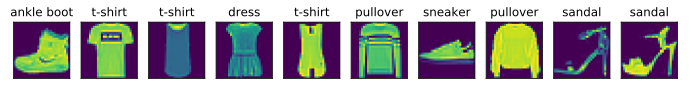

In [7]:
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

## 读取小批量

我们将在训练数据集上训练模型，并将训练好的模型在测试数据集上评价模型的表现。前面说过，`mnist_train`是`torch.utils.data.Dataset`的子类，所以我们可以将其传入`torch.utils.data.DataLoader`来创建一个读取小批量数据样本的DataLoader实例。

在实践中，数据读取经常是训练的性能瓶颈，特别当模型较简单或者计算硬件性能较高时。PyTorch的`DataLoader`中一个很方便的功能是允许使用多进程来加速数据读取。这里我们通过参数`num_workers`来设置4个进程读取数据。

## 读取数据的方式

```python
import torch.utils.data as Data
# features labels 为tensor ， 适合小样本的数据集，直接读入内存进行操作
batch_size =10
dataset = Data.TensorDataset(features, labels)
dataloader = Data.DataLoader(
    dataset=dataset,      # torch TensorDataset format
    batch_size=batch_size,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=2,              # 多线程来读数据
)
```

主要就是`TensorDataset`的构建，一个方法如上从内存数据中构建，另一种是从硬盘中读取：继承 torch Dataset类

```python
class data_set(torch.utils.data.Dataset):
def __init__(self, dataset_root_path, test=False):

    self.test = test

    # Build path list
    self.input_pairs, self.gt_key = create_input_list(
        dataset_root_path, test)

    def __len__(self):

    def __getitem__(self, idx):
        
    def get_gt_key(self):
```

主要是getitem len 等函数的建立

In [8]:
batch_size = 256
num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [9]:
start = time.time()
for X, y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))

3.19 sec


## 小结

- Fashion-MNIST是一个10类服饰分类数据集，之后章节里将使用它来检验不同算法的表现。
- 我们将高和宽分别为$h$和$w$像素的图像的形状记为$h \times w$或`(h，w)`。

In [10]:
from imp import reload
import dl_utils
reload(dl_utils)
train_dataloader, test_dataloader = dl_utils.load_data_fashion_mnist(batch_size = 256)

In [11]:
#初始化模型参数
import numpy as np
num_inputs = 784
num_outputs = 10

W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)

W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 



tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

## 实现softmax运算

在介绍如何定义softmax回归之前，我们先描述一下对如何对多维`Tensor`按维度操作。在下面的例子中，给定一个`Tensor`矩阵`X`。我们可以只对其中同一列（`dim=0`）或同一行（`dim=1`）的元素求和，并在结果中保留行和列这两个维度（`keepdim=True`）。

In [12]:
X = torch.tensor([[1, 2, 3], [4, 9, 6]]).float()
print(X.sum(dim=0, keepdim=True))
print(X.sum(dim=1, keepdim=True))

tensor([[ 5., 11.,  9.]])
tensor([[ 6.],
        [19.]])


In [13]:
def softmax(X):
    #input X with size [N, f]
    return torch.exp(X.float()) / torch.exp(X.float()).sum(dim = 1, keepdim = True)

def softmax2(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制    
from time import time
start = time()
print(softmax(X))
print(time() - start)

start = time()
print(softmax2(X))
print(time() - start)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0064, 0.9465, 0.0471]])
0.03091597557067871
tensor([[0.0900, 0.2447, 0.6652],
        [0.0064, 0.9465, 0.0471]])
0.0029938220977783203


In [14]:
print(torch.exp(X.float()))
print(torch.exp(X.float()).sum(dim = 1, keepdim = True))
print(torch.exp(X.float()) / torch.exp(X.float()).sum(dim = 1, keepdim = True))

tensor([[2.7183e+00, 7.3891e+00, 2.0086e+01],
        [5.4598e+01, 8.1031e+03, 4.0343e+02]])
tensor([[  30.1929],
        [8561.1113]])
tensor([[0.0900, 0.2447, 0.6652],
        [0.0064, 0.9465, 0.0471]])


In [15]:
X = torch.rand((2, 5))
X_prob = softmax(X)
print(X_prob, X_prob.sum(dim=1))
#可以看到，对于随机输入，我们将每个元素变成了非负数，且每一行和为1。

tensor([[0.1606, 0.2916, 0.2610, 0.1330, 0.1537],
        [0.1748, 0.1241, 0.2664, 0.2267, 0.2080]]) tensor([1.0000, 1.0000])


##  定义模型

有了softmax运算，我们可以定义上节描述的softmax回归模型了。这里通过`view`函数将每张原始图像改成长度为`num_inputs`的向量。

In [16]:
def net(X):
    return softmax(torch.mm(X.view(-1, num_inputs),W)+b)

print(W.size(), b.size())

torch.Size([784, 10]) torch.Size([10])


## 定义损失函数

上一节中，我们介绍了softmax回归使用的交叉熵损失函数。为了得到标签的预测概率，我们可以使用`gather`函数。在下面的例子中，变量`y_hat`是2个样本在3个类别的预测概率，变量`y`是这2个样本的标签类别。通过使用`gather`函数，我们得到了2个样本的标签的预测概率。与3.4节（softmax回归）数学表述中标签类别离散值从1开始逐一递增不同，在代码中，标签类别的离散值是从0开始逐一递增的。

In [17]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.LongTensor([0, 2])
y_hat.gather(1, y.view(-1, 1))

#取出 y label 对应的index 的y_hat 数值

tensor([[0.1000],
        [0.5000]])

In [18]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

## 计算分类准确率

给定一个类别的预测概率分布`y_hat`，我们把预测概率最大的类别作为输出类别。如果它与真实类别`y`一致，说明这次预测是正确的。分类准确率即正确预测数量与总预测数量之比。

为了演示准确率的计算，下面定义准确率`accuracy`函数。其中`y_hat.argmax(dim=1)`返回矩阵`y_hat`每行中最大元素的索引，且返回结果与变量`y`形状相同。相等条件判断式`(y_hat.argmax(dim=1) == y)`是一个类型为`ByteTensor`的`Tensor`，我们用`float()`将其转换为值为0（相等为假）或1（相等为真）的浮点型`Tensor`。

In [19]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim = 1) == y).float().mean().item()


In [20]:
y_hat = torch.tensor([[1,2,3,4],[2,6,5,0]])
print(y_hat.argmax(dim = 1))
#取出最大值对应的index
y_labels = torch.tensor([3,0])

print(y_hat.argmax(dim = 1) == y_labels)

print(accuracy(y_hat,y_labels))

tensor([3, 1])
tensor([1, 0], dtype=torch.uint8)
0.5


In [21]:
def evaluate_accuracy(dataloader, net):
    acc_sum, n = 0.0 , 0
    for data, label in dataloader:
        #print(data.view(-1,num_inputs).size())
        #break
        acc_sum += (net(data).argmax(dim=1) == label).float().sum().item()
        n += label.shape[0]
    return acc_sum / n

print(evaluate_accuracy(test_iter, net))
#log(n)

0.1444


同样使用小批量随机梯度下降来优化模型的损失函数。在训练模型时，迭代周期数`num_epochs`和学习率`lr`都是可以调的超参数。改变它们的值可能会得到分类更准确的模型。

In [22]:
num_epochs, lr = 5, 0.1
batch_size = 256
reload(dl_utils)
def train_classification_net(net, train_iter, test_iter, loss, num_epochs, batch_size, 
                             params=None, lr=None, optimizer=None):
    print('batch_size :{}'.format(batch_size))
    for epoch in range(num_epochs):

        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0

        for data, label in train_iter:

            out = net(data)

            l = loss(out,label).sum()



                    # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()

            l.backward()
            if optimizer is None:
                dl_utils.sgd(params, lr, batch_size)
            else:
                optimizer.step()  # “softmax回归的简洁实现”一节将用到

            #计算信息
            train_l_sum += l.item()
            train_acc_sum += (out.argmax(dim=1) == label).float().sum().item()
            n += label.shape[0]

        test_acc = evaluate_accuracy(test_iter, net)

        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
                  % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))
        
train_classification_net(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr = lr)    

batch_size :256
epoch 1, loss 0.7877, train acc 0.749, test acc 0.794
epoch 2, loss 0.5697, train acc 0.812, test acc 0.806
epoch 3, loss 0.5252, train acc 0.825, test acc 0.818
epoch 4, loss 0.5013, train acc 0.832, test acc 0.820
epoch 5, loss 0.4867, train acc 0.836, test acc 0.828


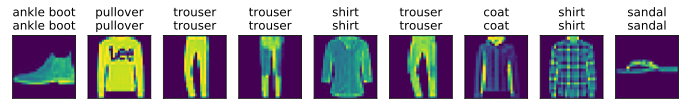

In [23]:
reload(dl_utils)
X,y = iter(test_iter).next()
true_labels = dl_utils.get_fashion_mnist_labels(y.numpy())
pred_labels = dl_utils.get_fashion_mnist_labels( net(X).argmax(dim=1).numpy() )

titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

dl_utils.show_fashion_mnist(X[0:9], titles[0:9])

## 小结

- 可以使用softmax回归做多类别分类。与训练线性回归相比，你会发现训练softmax回归的步骤和它非常相似：获取并读取数据、定义模型和损失函数并使用优化算法训练模型。事实上，绝大多数深度学习模型的训练都有着类似的步骤。


## softmax pytorch 版本


In [24]:
import torch
from torch import nn
from torch.nn import init
import torch.nn as nn
import numpy as np

In [25]:
batch_size = 256
train_iter, test_iter = dl_utils.load_data_fashion_mnist(batch_size)

## 定义和初始化模型

在3.4节（softmax回归）中提到，softmax回归的输出层是一个全连接层，所以我们用一个线性模块就可以了。因为前面我们数据返回的每个batch样本`x`的形状为(batch_size, 1, 28, 28), 所以我们要先用`view()`将`x`的形状转换成(batch_size, 784)才送入全连接层。

In [26]:
num_inputs = 28*28
num_class = 10

class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_class):
        super(LinearNet, self).__init__()
        self.lin = nn.Linear(num_inputs, num_class)
    
    def forward(self, x): # x shape: (batch, 1, 28, 28)
        return  self.lin(x.view(-1, num_inputs))
    
input_test = torch.randn((32,1,28,28))
net = LinearNet(num_inputs, num_class)
out = net(input_test)
print(out.shape)


init.normal_(net.lin.weight, mean=0, std=0.01)
init.constant_(net.lin.bias, val=0) 

torch.Size([32, 10])


Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

## softmax和交叉熵损失函数

如果做了上一节的练习，那么你可能意识到了分开定义softmax运算和交叉熵损失函数可能会造成数值不稳定。因此，PyTorch提供了一个包括softmax运算和交叉熵损失计算的函数。它的数值稳定性更好。

我们使用学习率为0.1的小批量随机梯度下降作为优化算法

In [27]:
reload(dl_utils)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

num_epochs = 5

dl_utils.train_classification_net(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

batch_size :256
epoch 1, loss 0.0031, train acc 0.750, test acc 0.782
epoch 2, loss 0.0022, train acc 0.812, test acc 0.791
epoch 3, loss 0.0021, train acc 0.826, test acc 0.812
epoch 4, loss 0.0020, train acc 0.831, test acc 0.794
epoch 5, loss 0.0019, train acc 0.836, test acc 0.823


- PyTorch提供的函数往往具有更好的数值稳定性。
- 可以使用PyTorch更简洁地实现softmax回归。